# XPCS&XSVS for Dose-Dependnet SAXS|Gi-SAXS Analysis
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_packages import *
from chxanalys.chx_xpcs_xsvs_jupyter_V1 import *
%matplotlib notebook
# %matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
# %reset -f  #for clean up things in the memory

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "
/opt/conda_envs/analysis/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Control Multi-Runs Parameters

In [118]:
#scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)

scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)


force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = True #False   #run waterfall analysis
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_one_time = True  #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = False #True #True #False    #run  two-time
run_four_time = False   #run  four-time
run_xsvs= True #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 3      #the intested single qth             
use_sqnorm = True #False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name
if scat_geometry == 'gi_saxs':run_xsvs= False 

In [3]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

## Make a directory for saving results

In [4]:
CYCLE = '2017_2'
path = '/XF11ID/analysis/%s/masks/'%CYCLE
username = getpass.getuser()
#username = 'jain'

#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)



Results from this analysis will be stashed in the directory /XF11ID/analysis/2017_2/sutton/Results/


## Load Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [5]:
mask_path = '/XF11ID/analysis/2017_2/masks/'
mask_name = 'Jun16_SAXS_10m.npy' 

<IPython.core.display.Javascript object>


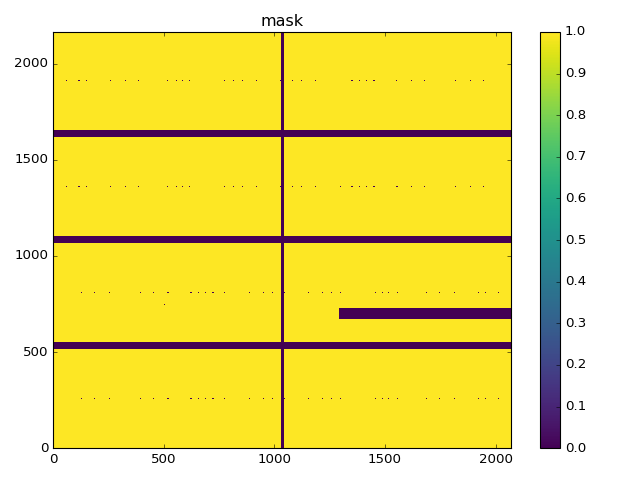

In [6]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = '%s_mask'%mask_name, reverse=True ) 
#mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
#np.save(  data_dir + 'mask', mask)
show_img(mask,image_name = 'mask', save=True, path=data_dir)
mask_load=mask.copy()

## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

# Two ways to get uid
* give start and stop time
* give uids as a list

In [7]:
#first way 
#start_time, stop_time = '2017-4-5 13:45:00', '2017-4-5 14:38:00'
#sids, uids, fuids = find_uids(start_time, stop_time)
#print(uids)

#Second way 
uids = np.array(   [  'ccb24c', 'a052b6', '6450ba'   ] ) 

#'2a1196'] (scan num: 21620) (Measurement: 750Hz, Tr=1 5k fr PS220_AUPEG50 )
#'fd9f80'] (scan num: 21621) (Measurement: 400Hz, Tr=.5 5k fr PS220_AUPEG50 )
#'7d18ad'] (scan num: 21623) (Measurement: 100Hz, Tr=.1 5k fr PS220_AUPEG50 )                    
#'13e83a'] (scan num: 21624) (Measurement: 10Hz, Tr=.1 5k fr PS220_AUPEG50 )  

 
fuids = np.array(   [  db[uid]['start']['uid'] for uid in uids ]  )
uid = uids[0]
print( uids )

#uid = uids[2]
uidstr = 'uid=%s'%uid

['ccb24c' 'a052b6' '6450ba']


In [8]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [9]:
#guids, buids = check_bad_uids( uids, mask, img_choice_N = 1, bad_uids_index=[1, 2] )

guids, buids = check_bad_uids( uids, mask, img_choice_N = 1, bad_uids_index=[ ] )
print( 'The good uids are: %s.\nThe good uids length is %s.'%(guids, len(guids)) )

The total and bad uids number are 3 and 0, repsectively.
The good uids are: ['ccb24c', 'a052b6', '6450ba'].
The good uids length is 3.


In [10]:
gfuids = fuids[np.array( [ np.where( uids ==  s )[0][0] for s in guids  ] )]
print( gfuids)

['ccb24ce9-2f7d-4307-ae31-b95da1b4a2ee'
 'a052b681-f15a-45cb-ba9d-4fe19c6b90db'
 '6450ba27-169c-4f4c-819f-57fa0ba1b465']


# Don't Change these lines below here

In [11]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [12]:
md = get_meta_data( uid )

In [13]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )
imgsa = apply_mask( imgs, mask )

The data are: Sliced and/or processed EigerImages2. Original repr:
    <Frames>
    Length: 10000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [14]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  'transmission',
         'det_distanc', 'beam_center_x', 'beam_center_y', ] )

suid--> ccb24c
number of images--> 10000
uid--> ccb24ce9-2f7d-4307-ae31-b95da1b4a2ee
scan_id--> 23710
start_time--> 2017-06-16 17:27:18
stop_time--> 2017-06-16 17:28:50
sample--> T3 SBA 15
Measurement--> T3 SBA 15 xpcs test  - 10 kframes at 200Hz, att 0.5
acquire period--> 0.005
exposure time--> 0.004989999812096357
transmission--> 0.5359472859055617
beam_center_x--> 1361.0
beam_center_y--> 1468.0


## Overwrite Some Metadata Due to Wrong Input

In [15]:
center = [   1360, 2167 - 1468]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))

center=[center[0], center[1]]


inc_x0 =  center[1]
inc_y0=   center[0]


dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )

setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

print_dict( setup_pargs )

lambda_--> 1.28548
timeperframe--> 0.005
dpix--> 0.0750000035623
Ldet--> 10093.0
exposuretime--> 0.004989999812096357
uid--> uid=ccb24c
path--> /XF11ID/analysis/2017_2/sutton/Results/
center--> [699, 1360]


# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [16]:
img_choice_N = 1
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uid)
if avg_img.max() == 0:
    print('There are no photons recorded fdata_diror this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

<IPython.core.display.Javascript object>


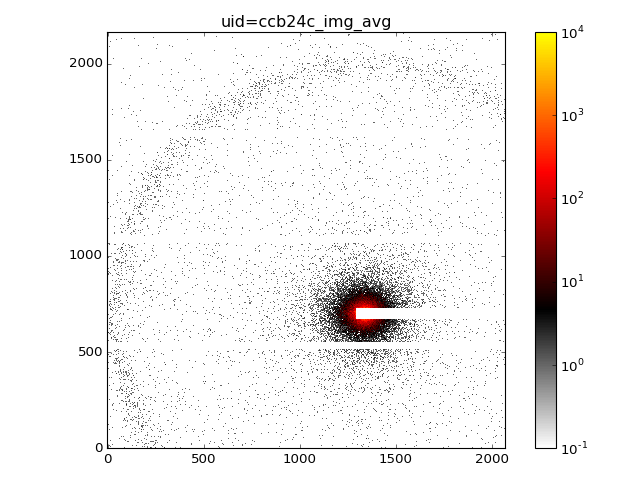

In [17]:
show_img( avg_img,  vmin=.1, vmax= 1e4, logs=True, aspect=1,
         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula )

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

# Load ROI 

In [18]:
fp = path + 'T3SBA15_roi_mask_Jun16.pkl'
fp = path + 'T3SBA15_roi_mask_Jun16_slim.pkl'

roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
print(fp)




if scat_geometry =='gi_saxs':
    
    fp = path + 'XX_roi_masks_June4.pkl'
    roi_masks,qval_dicts = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
    print(fp)

    fp = path + 'XX_qmap_June4.pkl'    
    print(fp)
    qr_map, qz_map, ticks, Qrs, Qzs,  Qr, Qz, inc_x0,refl_x0, refl_y0 = cpk.load( open(fp, 'rb' )  )


/XF11ID/analysis/2017_2/masks/T3SBA15_roi_mask_Jun16.pkl


# SAXS Scattering Geometry

<IPython.core.display.Javascript object>


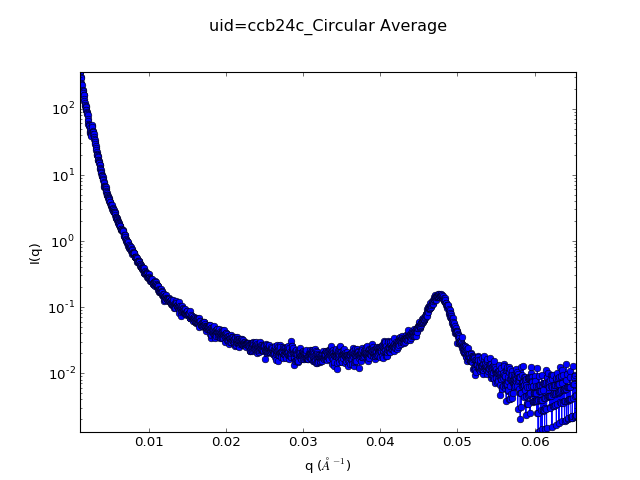

In [19]:
if scat_geometry =='saxs':
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 600)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, 
                      xlim=[q_saxs.min(), q_saxs.max()*0.9], ylim = [iq_saxs.min(), iq_saxs.max()] )
#mask =np.array( mask * hmask, dtype=bool) 


12


<IPython.core.display.Javascript object>


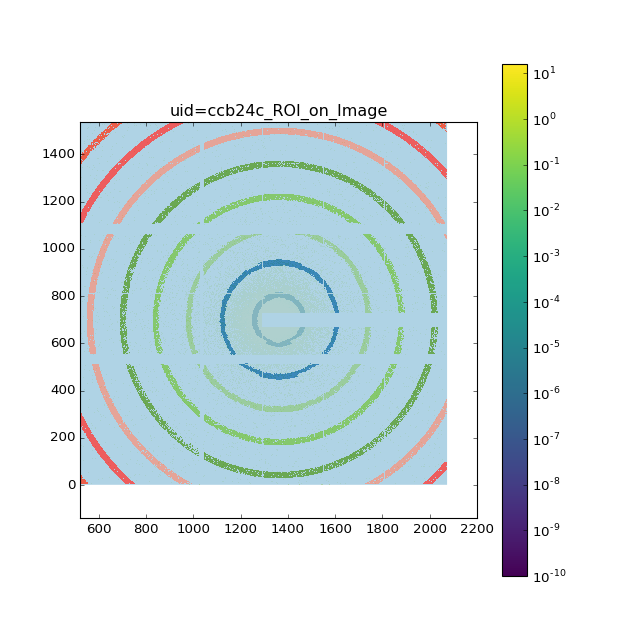

<IPython.core.display.Javascript object>


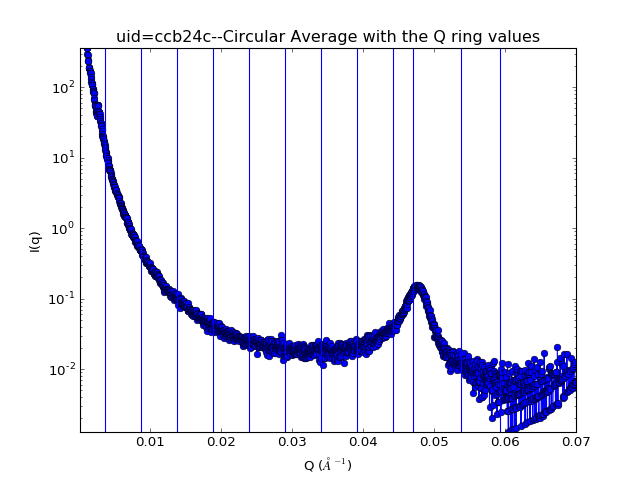

In [20]:
if scat_geometry =='saxs':    
    if run_fit_form:        
        form_res = fit_form_factor( q_saxs,iq_saxs,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])  
        
    qr = np.array( [qval_dict[k][0] for k in sorted( qval_dict.keys())] )
    print(len(qr))
    show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth = 840, alpha=.9,  
                     save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img),
                      vmax= 16, #np.max(avg_img),
                     aspect=1) 
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, xlim=[0.0001,0.07],
                  ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)

# GiSAXS Scattering Geometry

In [21]:
if scat_geometry =='gi_saxs':
    # Get Q-Map (Qz and Qr)
    ### Users put incident-Beam and Reflection_Beam Centers here!!!
    # Change these lines
    inc_x0=setup_pargs['center'][0]
    inc_y0=setup_pargs['center'][1]
    if incidence_angle == 0.14:    

        refl_x0 = 1066
        refl_y0 = 692
    if incidence_angle == 0.24:

        refl_x0 = 1066
        refl_y0 = 915
    
    # Don't Change these lines below here
    alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
    qx_map, qy_map, qr_map, qz_map = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )
    ticks_  = get_qzr_map(  qr_map, qz_map, inc_x0, Nzline=10,  Nrline=10   )
    ticks = ticks_[:4]
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks_, data= avg_img, uid= uidstr, path = data_dir   )

In [22]:
if scat_geometry =='gi_saxs':
    # Define Q-ROI
    #* Users provide the interested Qz and Qr here for XPCS analysis, e.g., qr start/end/number/width et.al
    # Change these lines

#     qz_start = 0.025
#     qz_end = 0.035
#     qz_num= 1
#     gap_qz_num = 1
#     qz_width = (qz_end - qz_start)/(qz_num +gap_qz_num)
    
    qz_start = 0.031
    qz_end = 0.041
    qz_num= 1
    gap_qz_num = 1
    qz_width = (qz_end - qz_start)/(qz_num +gap_qz_num)
    
    qr_start =  0.005
    qr_end = 0.055
    qr_num = 9
    gap_qr_num = 1
    qr_width = ( qr_end- qr_start)/(qr_num+gap_qr_num)

    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]
    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )

In [23]:
if scat_geometry =='gi_saxs':
    ### Change the below lines to if define another ROI, if define even more, just repeat this process
    define_second_roi = False  #True #False  #if True to define another line; else: make it False    
    if define_second_roi:    
        qval_dict1 = qval_dict.copy()
        roi_mask1 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Second ROI
    if define_second_roi:    
        qz_start2 = 0.04
        qz_end2 = 0.050
        qz_num2= 1
        gap_qz_num2 = 1
        qz_width2 = (qz_end2 - qz_start2)/(qz_num2 +gap_qz_num2)    
        qr_start2 =  0.002
        qr_end2 = 0.064
        qr_num2 = 10
        gap_qr_num2 = 5
        qr_width2 = ( qr_end2- qr_start2)/(qr_num2+gap_qr_num2)
        Qr2 = [qr_start2 , qr_end2, qr_width2, qr_num2]
        Qz2=  [qz_start2,   qz_end2,  qz_width2 , qz_num2 ] 
        roi_mask2, qval_dict2 = get_gisaxs_roi( Qr2, Qz2, qr_map, qz_map, mask= mask )
        qval_dict = update_qval_dict(  qval_dict1, qval_dict2 )
        roi_mask = update_roi_mask(  roi_mask1, roi_mask2 )
        
    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )        
    ## Get 1D Curve (Q||-intensity¶)
    qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0,  setup_pargs=setup_pargs )
    qr_1d_pds_label = list( qr_1d_pds.columns )
    plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=False, save=True, uid=uidstr, path = data_dir)

## Run_Does_Analysis

In [24]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_xpcs_xsvs_jupyter.py#

#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [25]:
guids

['ccb24c', 'a052b6', '6450ba']

In [26]:
good_start = 5

### Compress data for the series of uids

In [27]:
compress_multi_uids( guids, mask, force_compress= False,  bin_frame_number=1 )

UID: ccb24c is in processing...
Sliced and/or processed EigerImages2. Original repr:
    <Frames>
    Length: 10000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_ccb24ce9-2f7d-4307-ae31-b95da1b4a2ee.cmp.
UID: a052b6 is in processing...
Sliced and/or processed EigerImages2. Original repr:
    <Frames>
    Length: 10000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_a052b681-f15a-45cb-ba9d-4fe19c6b90db.cmp.
UID: 6450ba is in processing...
Sliced and/or processed EigerImages2. Original repr:
    <Frames>
    Length: 10000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_6450ba27-169c-4f4c-819f-57fa0ba1b465.cmp.
Done!


### Get two-time correlation functions for  the series of uids

In [119]:
if use_sqnorm:
    norm = get_pixelist_interp_iq( qp_saxs, iq_saxs, roi_mask, center)
else:
    norm=None

In [117]:
#norm

In [29]:
get_two_time_mulit_uids( guids, roi_mask,  norm= norm,  bin_frame_number=1, 
                        path= data_dir, force_generate=False )

UID: ccb24c is in processing...


100%|██████████| 12/12 [06:16<00:00, 27.82s/it]


The two time correlation function for uid=ccb24c is saved as /XF11ID/analysis/2017_2/sutton/Results/ccb24c/uid=ccb24c_g12b.
UID: a052b6 is in processing...


100%|██████████| 12/12 [06:15<00:00, 27.86s/it]


The two time correlation function for uid=a052b6 is saved as /XF11ID/analysis/2017_2/sutton/Results/a052b6/uid=a052b6_g12b.
UID: 6450ba is in processing...


100%|██████████| 12/12 [06:15<00:00, 27.83s/it]


The two time correlation function for uid=6450ba is saved as /XF11ID/analysis/2017_2/sutton/Results/6450ba/uid=6450ba_g12b.


### Calculate dose-dependent one-time correlation functions for the series of uids

##### Define dose to get dose-frame number

In [30]:
md['transmission']

0.5359472859055617

In [52]:
trans_min = 0.1

In [103]:
N = len(imgs)
print(N)
#exposure_dose = trans_min * exposuretime* np.int_([   N/16, N/8, N/4 ,N/2, 3*N/4, N*.95 ] )

exposure_dose = trans_min * exposuretime* np.int_([   N/64, N/32,  N/16, N/8, N/4, N/2 ] )

# exposure_dose = md['transmission'] * exposuretime* np.int_([   N/8, N/4 ,N/2, 3*N/4, N ] )
exposure_dose

10000


array([ 0.077844  ,  0.15568799,  0.31187499,  0.62374998,  1.24749995,
        2.49499991])

In [104]:
10000/16

625.0

In [105]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_xpcs_xsvs_jupyter_V1.py

In [106]:
#taus_uids, g2_uids = get_series_one_time_mulit_uids(  guids,  qval_dict, good_start=good_start,  
#                    path= data_dir, exposure_dose = exposure_dose,  num_bufs =8, save_g2= False    )

In [107]:
guids

['ccb24c', 'a052b6', '6450ba']

In [108]:
taus_uids, g2_uids = get_series_one_time_mulit_uids(  guids,  
                                                    qval_dict, good_start=good_start,  
                    path= data_dir, exposure_dose = exposure_dose,  num_bufs =8, save_g2= False,
                                                   dead_time = 0, trans = None  )

UID: ccb24c is in processing...
uid: ccb24c--> fra_num_by_dose: [ 29  58 116 233 466 932]
UID: a052b6 is in processing...
uid: a052b6--> fra_num_by_dose: [ 153  307  615 1230 2461 4922]
UID: 6450ba is in processing...
uid: 6450ba--> fra_num_by_dose: [ 15  31  62 125 250 500]


In [109]:
#'2a1196'] (scan num: 21620) (Measurement: 750Hz, Tr=1 5k fr PS220_AUPEG50 )
#'fd9f80'] (scan num: 21621) (Measurement: 400Hz, Tr=.5 5k fr PS220_AUPEG50 )
#'7d18ad'] (scan num: 21623) (Measurement: 100Hz, Tr=.1 5k fr PS220_AUPEG50 )                    
#'13e83a'] (scan num: 21624) (Measurement: 10Hz, Tr=.1 5k fr PS220_AUPEG50 ) 

### Plot dose-dependent one-time correlation functions for the series of uids

In [110]:
filename = 'dose_g2_analysis'

In [111]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_xpcs_xsvs_jupyter_V1.py

<IPython.core.display.Javascript object>


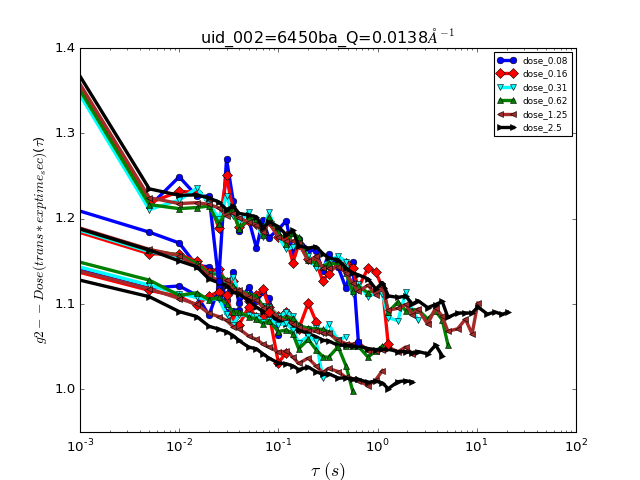

In [116]:
qth_interest =  2

plot_dose_g2( taus_uids, g2_uids, qth_interest= qth_interest, ylim=[0.95, 1.4], vshift= 0.0,
                 qval_dict = qval_dict, fit_res= None,  geometry= scat_geometry,
                 filename= 'oneq_dose_analysis',  legend_size = 8,
                path= data_dir, function= None,  ylabel='g2_Dose', g2_labels= None, append_name=  '' )

<IPython.core.display.Javascript object>


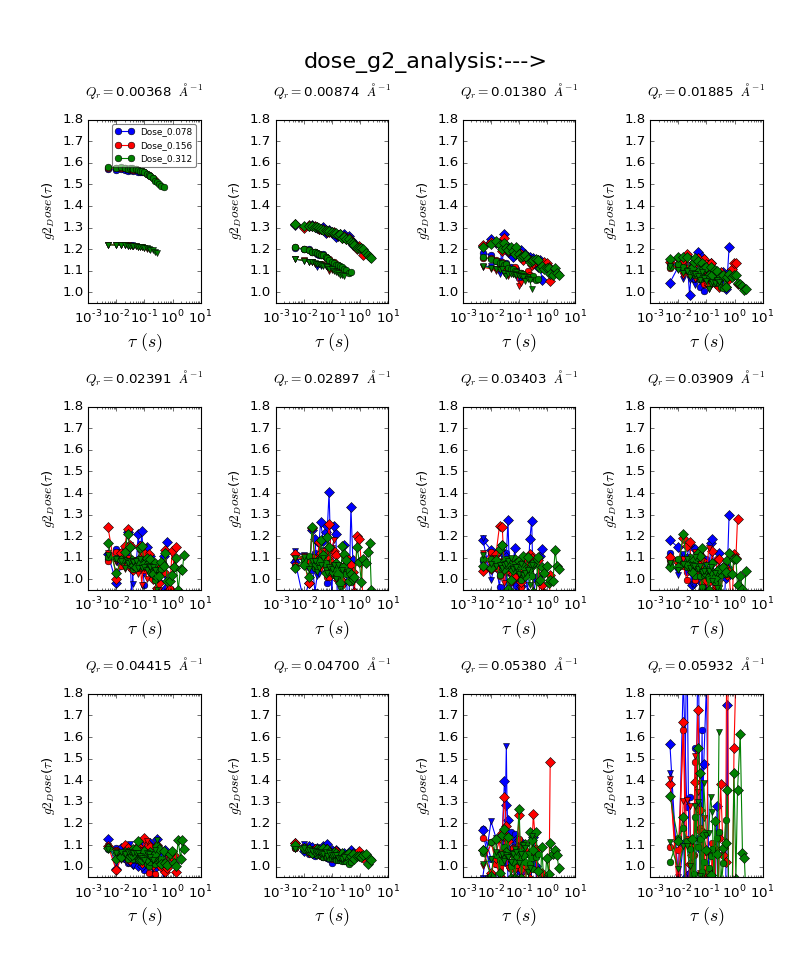

In [81]:
plot_dose_g2( taus_uids, g2_uids, ylim=[0.95, 1.8], vshift= 0.0,
                 qval_dict = qval_dict, fit_res= None,  geometry= scat_geometry,filename= filename, 
                path= data_dir, function= None,  ylabel='g2_Dose', g2_labels= None, append_name=  '' )

### Attach each g2 result to the corresponding olog entry

In [48]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname =  data_dir  +  filename  + '.png'
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= fuids[-1], text='Add a dose dependent XPCS Analysis png file', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

The url=https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog was successfully updated with Add a dose dependent XPCS Analysis png file and with the attachments


In [49]:
fuids[-1]

'6450ba27-169c-4f4c-819f-57fa0ba1b465'

# The End!